In [59]:
import pandas as pd # Dataframe (allows for multiple different structures/data types in one database frame)
import numpy as np # Array style (only one data-type is allowed)
import matplotlib.pyplot as plt   # The default processing plot platform for python
import seaborn as sns  # A fancier way to plot things with nice animations and color

import scipy.stats as stats
import statsmodels.api as sm      # Scipy or sklearn or statmodels.api
import statsmodels.formula.api as smf # A way to do forward and backward selections

from statsmodels.graphics.plot_grids import scatter_ellipse
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.iolib.table import (SimpleTable, default_txt_fmt)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

import matplotlib.lines as mlines
import matplotlib.transforms as mtransform


import random
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn import metrics

%matplotlib inline
import os
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.model_selection import GroupShuffleSplit
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [92]:
##### THE BELOW CODE IS ADAPTED FROM KOEN PETERS BLOG POST: 
#https://towardsdatascience.com/predictive-maintenance-of-turbofan-engines-ec54a083127

In [93]:
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [94]:
index_names = ['engine_id', 'cycle_num']
operation_names = ['condition_1', 'condition_2', 'condition_3']
sensor_names = ['sensor_{}'.format(i) for i in range(1,22)] 
col_names = index_names + operation_names + sensor_names


train = pd.read_csv(('train_data.csv'), header=0, names=col_names)
test = pd.read_csv(('test_data.csv'), header=0, names=col_names)
y_test = pd.read_csv(('RUL_forecast_length.csv'), header=0, names=['RUL'])


train.head()

,engine_id,cycle_num,condition_1,condition_2,condition_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [95]:
def add_remaining_useful_life(df):
    
    grouped_by_unit = df.groupby(by="engine_id")
    max_cycle = grouped_by_unit["cycle_num"].max()
    
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='engine_id', right_index=True)
    
    remaining_useful_life = result_frame["max_cycle"] - result_frame["cycle_num"]
    result_frame["RUL"] = remaining_useful_life
    
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[index_names+['RUL']]

,engine_id,cycle_num,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187
...,...,...,...
9904,50,194,4
9905,50,195,3
9906,50,196,2
9907,50,197,1


In [96]:
X_train = train[sensor_names].copy()
y_train = train['RUL'].copy()
y_train_clipped = y_train.clip(upper=125)

X_test = test.drop(['cycle_num']+operation_names, axis=1).groupby('engine_id').last().copy()  # get the last row of each engine

In [97]:
scaler = MinMaxScaler()
scaler.fit(X_train[sensor_names])
X_train_scaled = X_train.copy()
X_train_scaled[sensor_names] = pd.DataFrame(scaler.transform(X_train[sensor_names]), columns=sensor_names)


X_test_scaled = X_test.copy()
X_test_scaled[sensor_names] = pd.DataFrame(scaler.transform(X_test[sensor_names]), columns=sensor_names, index=X_test.index)

In [98]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)  

def train_val_group_split(X, y, gss, groups, print_groups=True):
    
    for idx_train, idx_val in gss.split(X, y, groups=groups):
        if print_groups:
            print('train_split_engines', train.iloc[idx_train]['engine_id'].unique(), '\n')
            print('validate_split_engines', train.iloc[idx_val]['engine_id'].unique(), '\n')

        X_train_split = X.iloc[idx_train].copy()
        y_train_split = y.iloc[idx_train].copy()
        X_val_split = X.iloc[idx_val].copy()
        y_val_split = y.iloc[idx_val].copy()
    return X_train_split, y_train_split, X_val_split, y_val_split

split_result = train_val_group_split(X_train_scaled, y_train_clipped, gss, train['engine_id'], print_groups=True)
X_train_split_scaled, y_train_clipped_split_scaled, X_val_split_scaled, y_val_clipped_split_scaled = split_result

train_split_engines [ 1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 19 21 22 23 24 25 28 29
 30 32 34 35 36 37 38 39 41 42 43 44 45 47 48 50] 

validate_split_engines [14 18 20 26 27 31 33 40 46 49] 



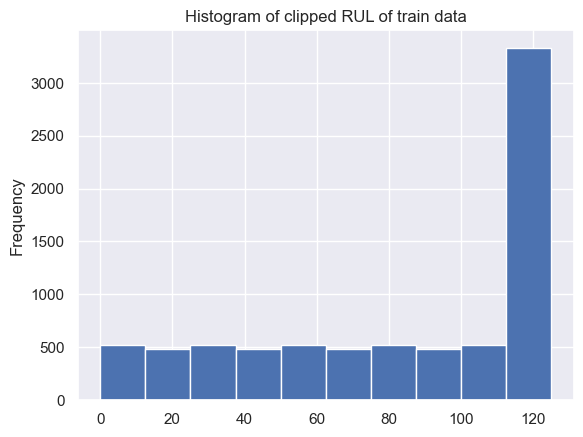

In [99]:
plt.figure()
y_train_clipped_split_scaled.plot(kind='hist')
plt.title("Histogram of clipped RUL of train data")
plt.show()
plt.close()

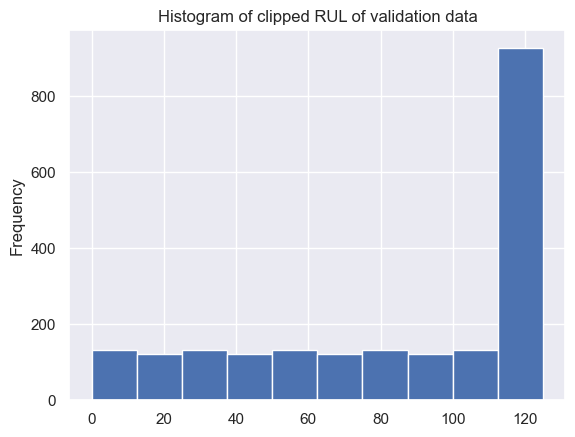

In [100]:
plt.figure()
y_val_clipped_split_scaled.plot(kind='hist')
plt.title("Histogram of clipped RUL of validation data")
plt.show()
plt.close()

In [101]:
#Distribution of val & train clipped RUL is similar. This is good, so we can move forward

In [102]:
train_cols = sensor_names
input_dim = len(train_cols)

model = Sequential()
model.add(Dense(16, input_dim=input_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

In [103]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('reproducible_primer_weights.h5')  # important, weights are saved after compiling the model

In [104]:
epochs = 20

model.compile(loss='mean_squared_error', optimizer='adam')
model.load_weights('reproducible_primer_weights.h5')

history = model.fit(X_train_split_scaled[train_cols], y_train_clipped_split_scaled,
                    validation_data=(X_val_split_scaled[train_cols], y_val_clipped_split_scaled),
                    epochs=epochs)

Epoch 1/20
246/246 [==============================] - 1s 2ms/step - loss: 4136.3818 - val_loss: 1286.9633
Epoch 2/20
246/246 [==============================] - 0s 2ms/step - loss: 724.8723 - val_loss: 628.0788
Epoch 3/20
246/246 [==============================] - 0s 2ms/step - loss: 437.0977 - val_loss: 531.3814
Epoch 4/20
246/246 [==============================] - 0s 2ms/step - loss: 391.3319 - val_loss: 499.6331
Epoch 5/20
246/246 [==============================] - 0s 2ms/step - loss: 369.0103 - val_loss: 508.7865
Epoch 6/20
246/246 [==============================] - 0s 2ms/step - loss: 354.2902 - val_loss: 488.3134
Epoch 7/20
246/246 [==============================] - 0s 2ms/step - loss: 345.1650 - val_loss: 463.1919
Epoch 8/20
246/246 [==============================] - 0s 2ms/step - loss: 338.1233 - val_loss: 453.2244
Epoch 9/20
246/246 [==============================] - 0s 2ms/step - loss: 330.5194 - val_loss: 444.2838
Epoch 10/20
246/246 [==============================] - 0s 2ms/

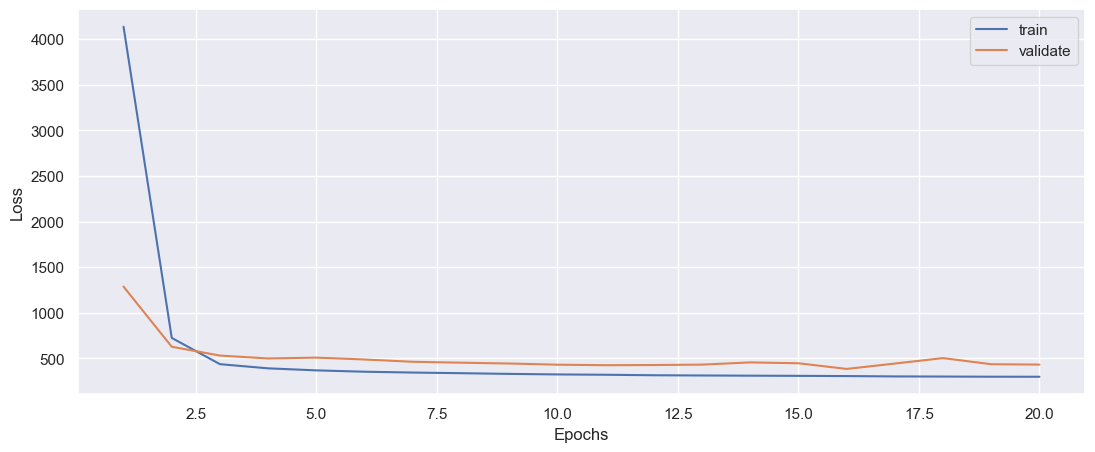

In [105]:
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [106]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [107]:
# predict and evaluate
y_hat_train = model.predict(X_train_scaled[train_cols])
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = model.predict(X_test_scaled[train_cols])
evaluate(y_test, y_hat_test)

310/310 [==============================] - 0s 1ms/step
train set RMSE:18.001847969709278, R2:0.8143557043316213
2/2 [==============================] - 0s 3ms/step
test set RMSE:25.662451144384047, R2:-2.162359657805032


In [112]:
def add_operating_condition(df):
    df_op_cond = df.copy()
    

    df_op_cond['condition_1'] = df_op_cond['condition_1'].round()
    
    df_op_cond['condition_2'] = df_op_cond['condition_2'].round(decimals=2)
    
    df_op_cond['op_cond'] = df_op_cond['condition_1'].astype(str) + '_' + \
                        df_op_cond['condition_2'].astype(str) + '_' + \
                        df_op_cond['condition_3'].astype(str)
    
    return df_op_cond

In [113]:
X_train_condition = add_operating_condition(train)
X_test_condition = add_operating_condition(test)

In [114]:
def condition_scaler(df_train, df_test, sensor_names):
    # apply operating condition specific scaling
    scaler = StandardScaler()
    for condition in df_train['op_cond'].unique():
        scaler.fit(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
    return df_train, df_test

In [115]:
X_train_condition_scaled, X_test_condition_scaled = condition_scaler(X_train_condition, X_test_condition, sensor_names)

In [116]:
X_test_condition_scaled.head()

,engine_id,cycle_num,condition_1,condition_2,condition_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,op_cond
0,51,1,0.0,-0.0,100.0,0.0,-1.669944,-1.093587,0.018535,-1.776357e-15,...,-1.358827,0.263154,-1.371636,-3.469447e-18,-1.363367,0.0,0.0,1.422281,0.261165,0.0_-0.0_100.0
1,51,2,-0.0,-0.0,100.0,0.0,-1.135164,-1.524353,-1.181712,0.000000e+00,...,-1.506851,0.009538,-1.293781,-3.469447e-18,-1.400301,0.0,0.0,0.047032,0.480949,-0.0_-0.0_100.0
2,51,3,0.0,-0.0,100.0,0.0,-0.360121,0.212277,-1.116692,-1.776357e-15,...,-1.223432,-0.111974,-1.019229,-3.469447e-18,-0.725227,0.0,0.0,1.973303,0.517122,0.0_-0.0_100.0
3,51,4,-0.0,-0.0,100.0,0.0,-0.488801,-2.730308,-1.176314,0.000000e+00,...,-1.373165,0.126737,-1.351910,-3.469447e-18,-0.129038,0.0,0.0,0.373713,1.739869,-0.0_-0.0_100.0
4,51,5,0.0,0.0,100.0,0.0,-1.150442,-0.472012,-2.287403,-1.776357e-15,...,-1.023318,0.143208,-1.047762,-3.469447e-18,-1.426585,0.0,0.0,1.262174,1.078287,0.0_0.0_100.0


In [117]:
drop_sensors = ['sensor_1','sensor_5','sensor_6','sensor_10','sensor_16','sensor_18','sensor_19']
remaining_sensors = [element for element in sensor_names if element not in drop_sensors]

In [118]:
split_result = train_val_group_split(X_train_condition_scaled, y_train_clipped, gss, train['engine_id'], print_groups=False)
X_train_split_condition_scaled, y_train_clipped_split_condition_scaled = split_result[:2]
X_val_split_condition_scaled, y_val_clipped_split_condition_scaled = split_result[2:]

In [119]:
input_dim = len(X_train_split_condition_scaled[remaining_sensors].columns)

model = Sequential()
model.add(Dense(16, input_dim=input_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

In [120]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('condition_normalized_weights_remaining_sensors.h5')

In [121]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.load_weights('condition_normalized_weights_remaining_sensors.h5')

history = model.fit(X_train_split_condition_scaled[remaining_sensors], y_train_clipped_split_condition_scaled,
                    validation_data=(X_val_split_condition_scaled[remaining_sensors], y_val_clipped_split_condition_scaled),
                    epochs=epochs)

Epoch 1/20
246/246 [==============================] - 1s 2ms/step - loss: 3510.5962 - val_loss: 1077.3837
Epoch 2/20
246/246 [==============================] - 0s 2ms/step - loss: 557.4794 - val_loss: 661.8779
Epoch 3/20
246/246 [==============================] - 0s 2ms/step - loss: 408.0304 - val_loss: 505.8681
Epoch 4/20
246/246 [==============================] - 1s 2ms/step - loss: 341.5620 - val_loss: 431.1582
Epoch 5/20
246/246 [==============================] - 1s 2ms/step - loss: 315.2862 - val_loss: 425.1265
Epoch 6/20
246/246 [==============================] - 1s 2ms/step - loss: 304.8197 - val_loss: 392.4479
Epoch 7/20
246/246 [==============================] - 0s 2ms/step - loss: 296.9360 - val_loss: 384.5950
Epoch 8/20
246/246 [==============================] - 0s 2ms/step - loss: 290.9080 - val_loss: 362.2820
Epoch 9/20
246/246 [==============================] - 1s 2ms/step - loss: 285.2088 - val_loss: 407.2959
Epoch 10/20
246/246 [==============================] - 0s 2ms/

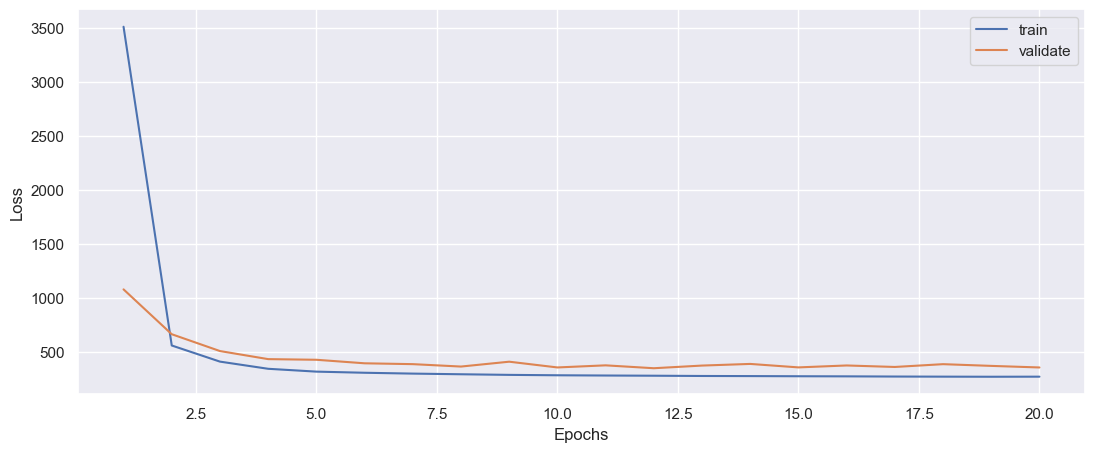

In [122]:
plot_loss(history)

In [123]:
# predict and evaluate
y_hat_train = model.predict(X_train_condition_scaled[remaining_sensors])
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = model.predict(X_test_condition_scaled[remaining_sensors])
evaluate(y_test, y_hat_test)

310/310 [==============================] - 0s 1ms/step
train set RMSE:16.80736521353348, R2:0.8381745944593972
201/201 [==============================] - 0s 986us/step


ValueError: Found input variables with inconsistent numbers of samples: [50, 6412]